In [1]:
import sys
sys.path.append('../../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities,Kron_Choi
from qiskit.compiler import transpile
from utils_qiskit import save_results
from qiskit.providers.ibmq.managed import IBMQJobManager  
from QuantumTomography import RandomUnitary             

In [2]:
IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
provider = IBMQ.get_provider(hub='ibm-q-research-2', group='csic-1', project='main')

In [3]:
backend = provider.get_backend('ibm_perth')
simulator = Aer.get_backend('aer_simulator')
job_manager = IBMQJobManager()

In [4]:
# 0-1-2
#   3
# 4-5-6

parall_qubits_all = [ [(0,1)],
                    [(0,3)],
                    [(0,5)],
                    [(0,6)]
                    ] 

In [5]:
job_ids = [ 
[    'e3eee16419e34ac088111184c44c4b29-16636849537826407',
'dd1ffe1d36f748c6993f7f30ce9c80e7-16636849570615067',
'28c902918ca84ce19309bf660acedcc6-16636849604129698',
'be7959e65e0b4c15858b094bcd70545c-16636849637521367',
'0560d841e212477cbe655bc139e69221-16636849671255348'],
['798c028f057d4711817e0f86f8a0f010-16636849706429129',
'ee0d3e5f45da47ffb42c4470c39bb575-16636849740484817',
'bb3911a54bbe415fa4c3c51f180f97c8-16636849774811127',
'a26c92610ba04896983530e0fceaca5c-1663684980843532',
'613b782629304f8080dc9ee3f0a6889e-16636849846101515'],
['61c2e0ce5a9c4a68b3cc096cd13fa272-16636849884998367',
'c149d05eca3240e5a94dc369d3832aac-1663684991977888',
'097b646c4e104288ab9f09555599ab9c-16636849950838802',
'ac07f29b953148a78c9b26e8f7a00177-16636849987742093',
'5cfff37735134018b04ed4bb87470b25-16636850020372348'],
['4fd8cd59f31843ccb893356afb00a1af-16636850056841366',
'965300891cc4443ab8b428bbe40af4c7-16636850091325965',
'296f0452061a4e3db2261cf1e024f2d8-16636850124951134',
'5d24d46d5ceb493292d9befe6f57ac8e-16636850160394702',
'5c0bdf02224345979c1ff72b05308244-16636850191251469']]

In [6]:
# results_mc = []

# for j in range(len(parall_qubits_all)) :
#     results = []
#     for k in range(5):
#         job = job_manager.retrieve_job_set( job_ids[j][k], provider )
#         results_qiskit = job.results().combine_results()
#         save_results( results_qiskit, name = job_ids[j][k], folder = 'data_correlations' ) 
#         qndmt = device_process_measurement_tomography( backend, parall_qubits=[parall_qubits_all[j]] )
#         circuits_qndmt = qndmt.circuits()
#         results_tomo   = qndmt.fit( results_qiskit, paralell=True, gate_set=True ) 
#         results.append( results_tomo )
#     results_mc.append(results) 

In [7]:
# np.save( 'data_correlations/results_tomography_v3', np.array(results_mc, dtype=object) )

In [8]:
results_mc = np.load('data_correlations/results_tomography_v3.npy', allow_pickle=True )

In [9]:
results_mc[0][0].double

In [10]:
quantities_mc = []
correlation_mc = []
for j in range(5):
    correlation = []
    quantities  = []
    for k in range(len(job_ids)) :
        chois_single = results_mc[k][j].single.chois 
        povms_single = results_mc[k][j].single.povms
        chois_double = results_mc[k][j].double[0].chois
        povms_double = results_mc[k][j].double[0].povms
        Fs = [ Quantities( povms_single[0], chois_single[0]  ),
                Quantities( povms_single[1], chois_single[1] ),
                Quantities( povms_double[0], chois_double[0]  ) ]
        Qs = Cross_Quantities( povms_single[0], chois_single[0],
                                povms_single[1], chois_single[1],
                                povms_double[0], chois_double[0]
                            )
        quantities.append( Fs )
        correlation.append( Qs )
    quantities_mc.append(quantities)
    correlation_mc.append(correlation)
quantities_mc = np.array(quantities_mc)
correlation_mc = np.array(correlation_mc)

In [11]:
rFs_mc = []
for m in range(5):
    rFs = []
    for j in range(4):
        F0  = quantities_mc[m][j][0][0]
        F1  = quantities_mc[m][j][1][0]
        F01 = quantities_mc[m][j][2][0]
        rF  = abs(F01 - F0*F1)/(F0*F1) 
        rFs.append( rF )
    rFs_mc.append( rFs )

rQs_mc = []
for m in range(5):
    rQs = []
    for j in range(4):
        Q0  = quantities_mc[m][j][0][1]
        Q1  = quantities_mc[m][j][1][1]
        Q01 = quantities_mc[m][j][2][1]
        rQ  = abs( Q01 - Q0*Q1 )/( Q0*Q1 ) 
        rQs.append( rQ )
    rQs_mc.append( rQs )

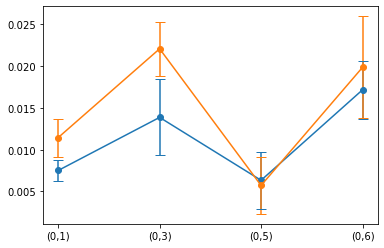

In [12]:
cF = np.mean( rFs_mc, axis=0 )
dcF = np.std( rFs_mc, axis=0 )

cQ = np.mean( rQs_mc, axis=0 )
dcQ = np.std( rQs_mc, axis=0 )

plt.errorbar( x=range(4), y=cF, yerr=dcF, fmt='-o', capsize=5 )
plt.errorbar( x=range(4), y=cQ, yerr=dcQ, fmt='-o', capsize=5 )
plt.xticks( range(4), labels=['(0,1)','(0,3)','(0,5)','(0,6)']);

In [13]:
correlation_mean = np.mean( correlation_mc, axis=0 )
correlation_std  = np.std( correlation_mc, axis=0 )

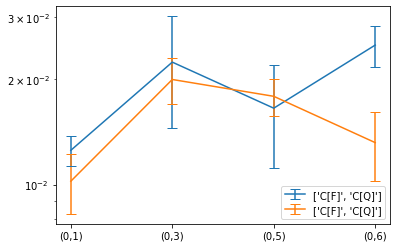

In [14]:
fig, ax = plt.subplots()
ax.set_yscale('log')
for j in range(2):
    plt.errorbar(range(4), correlation_mean[:,j], yerr=correlation_std[:,j], label=[ 'C[F]', 'C[Q]' ], capsize=5 )
plt.xticks( range(4), labels=['(0,1)','(0,3)','(0,5)','(0,6)']);
plt.legend(loc='best')
plt.savefig('fig_correlations_distance.png')